## Part I : Global includes



In [43]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import torch
import numpy as np
import cv2
import tensorflow as tf

# Uncomment to disable GPU usage.
# This is required for some models like Pridnet which has too many traininable parameters
tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
import random

import data_importer

In [44]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Part II : Loading test images

In [45]:
from dataloader_lodopab_ct import get_validation_dataloader
noisy_dataset = get_validation_dataloader("C:/Users/Tarun/Downloads/ground_truth_validation")

number of image paths :  28
validation data image len : , 28


In [46]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))

    # Reconstruct the image by placing each patch in its corresponding position
    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)

noisy_array = [None] * 28
print(len(noisy_dataset))
for i, data in enumerate(noisy_dataset):
    noisy_array[i] = reconstruct_image_from_patches(torch.squeeze(data[i], axis=0), 8)
    if i == 28:
        break
noisy_array = np.array(noisy_array)
print(noisy_array)

28
[[[[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [7.75017217e-02]
   [4.88339812e-02]
   [3.18426341e-02]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [1.17237854e-04]
   ...
   [1.17917523e-01]
   [7.84751102e-02]
   [5.14293462e-02]]

  [[3.37790087e-04]
   [1.48442909e-04]
   [1.93292042e-04]
   ...
   [1.70333326e-01]
   [1.23517409e-01]
   [8.70506838e-02]]

  ...

  [[7.96009786e-04]
   [3.49809008e-04]
   [0.00000000e+00]
   ...
   [2.26467520e-01]
   [2.35247955e-01]
   [2.43603826e-01]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [2.34824181e-01]
   [2.44176477e-01]
   [2.51705706e-01]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [2.41032094e-01]
   [2.50189573e-01]
   [2.56499588e-01]]]


 [[[0.00000000e+00]
   [1.14347786e-03]
   [1.49409124e-03]
   ...
   [2.40250994e-02]
   [1.62896775e-02]
   [8.19958560e-03]]

  [[0.00000000e+00]
   [5.02504932e-04]
   [6.56583055e-04]
   ...
   [3.34154777e-02

Visualization of the noisy / ground truth image pair

In [ ]:
from data_importer import denormalize, trunc

with torch.no_grad():    
    for i, data in enumerate(noisy_array):
        plt.imshow(trunc(denormalize(data)), vmin=-160.0, vmax=240.0, cmap='gray')
        plt.show()

### Part III : Setup for Inference

In [47]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    a = np.abs(np.min(predicted_image))
    b = np.max(predicted_image)
    
    #predicted_image = predicted_image * (b - a) + a
    return predicted_image[0]

def inference_batch_images(model, noisy_images):
    input_image = noisy_images

    predicted_image = model.predict(input_image).astype(np.float64)
    return predicted_image

In [48]:
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=-1)

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio
import sys
sys.path.append('../')

from metrics import compute_SSIM, compute_PSNR
from skimage.metrics import mean_squared_error  as mse

def calculate_psnr(original_image, reconstructed_image,range=400):
    return peak_signal_noise_ratio(original_image, reconstructed_image,data_range=range) 

    psnr_value = peak_signal_noise_ratio(original_image, reconstructed_image, data_range=240+160)
    return psnr_value

def calculate_ssim(original_image, reconstructed_image, range=400.0):    
    ssim_value = ssim(original_image.astype(np.int16), reconstructed_image.astype(np.int16), win_size=11, channel_axis=2, data_range=range)
    return ssim_value

def calculate_rmse(original_image, reconstructed_image):
    return mse(original_image, reconstructed_image)

def visualize_predictions(model, X_test,  n, predictions, model_name):
    random_numbers = list(range(n)) # not very random
    for i in random_numbers:
        gt_image= X_test[i].astype(np.float16)
        predicted_image = predictions[i].astype(np.float16)

        if predicted_image.shape[-1] == 3:
            predicted_image = rgb2gray(predicted_image)
                                
            
        psnr_recon =  calculate_psnr(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))
        ssim_recon = calculate_ssim(trunc(denormalize(gt_image)),  trunc(denormalize(predicted_image)))
        rmse_recon = calculate_rmse(trunc(denormalize(gt_image)),  trunc(denormalize(predicted_image)))
        
        psnr_recon = round(psnr_recon, 4)
        ssim_recon = round(ssim_recon, 4)
        rmse_recon = round(rmse_recon, 4)
        
        f, axarr = plt.subplots(1,2, figsize=(21,21))

        axarr[0].imshow(trunc(denormalize(gt_image)), cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[0].set_title("QD Image")
        axarr[0].set_axis_off()
        axarr[1].imshow(trunc(denormalize(predicted_image)),  cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[1].set_title("{} Predicted Image : PSNR={}\nSSIM={}\nRMSE={}".format(model_name, psnr_recon, ssim_recon, rmse_recon))
        axarr[1].set_axis_off()
        
        plt.show()

In [49]:
from skimage.metrics import peak_signal_noise_ratio

def get_average_metrics(predicted_images,  _noisy_array):
    psnr_original_mean = 0
    psnr_prediction_mean = 0

    ssim_original_mean = 0
    ssim_prediction_mean = 0

    mse_original_mean = 0
    mse_prediction_mean = 0

    i = 0
    for  gt_img, predicted_img in zip(noisy_array, predicted_images):
        predicted_img=  predicted_images[i]
        if predicted_img.shape[-1] == 3:
            predicted_img = rgb2gray(predicted_img)
            
        psnr_recon =  calculate_psnr(trunc(denormalize(gt_img)), trunc(denormalize(predicted_img)))
        ssim_recon = calculate_ssim(trunc(denormalize(gt_img)),  trunc(denormalize(predicted_img)))
        rmse_recon = calculate_rmse(trunc(denormalize(gt_img)),  trunc(denormalize(predicted_img)))

        psnr_prediction_mean += psnr_recon
        
        ssim_prediction_mean += ssim_recon

        mse_prediction_mean += rmse_recon
        
        i = i + 1        
    
    psnr_prediction_mean/=noisy_array.shape[0]

    ssim_prediction_mean/=noisy_array.shape[0]

    mse_prediction_mean/=noisy_array.shape[0]
    
    print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

    print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

    print("Predicted average gt-predicted MSE->", mse_prediction_mean)
    
    return round(psnr_prediction_mean, 4), round(ssim_prediction_mean, 4), round(mse_prediction_mean, 4)


## Part IV : Evaluation of each model

## Model 1 : Hformer (for base reference)

In [50]:
sys.path.append('../denoising-models/hformer_vit/model/')
sys.path.append('../denoising-models/hformer_vit/')
from hformer_model_extended import get_hformer_model, PatchExtractor

hformer_model = get_hformer_model(num_channels_to_be_generated=64, name="hformer_model_extended")
hformer_model.build(input_shape=(None, 64, 64, 1))
hformer_model.load_weights('../denoising-models/hformer_vit/test/experiments/full_dataset/hformer_64_channel_custom_loss_epochs_48.h5')
print('Model summary : ')
print(hformer_model.summary())

Model summary : 
Model: "hformer_model_extended"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_projection_layer (Inp  multiple                 320       
 utProjectionLayer)                                              
                                                                 
 output_projection_layer (Ou  multiple                 257       
 tputProjectionLayer)                                            
                                                                 
 conv_net_block_1 (Convoluti  multiple                 36416     
 onBlock)                                                        
                                                                 
 conv_net_block_2 (Convoluti  multiple                 36416     
 onBlock)                                                        
                                                                 
 downsampling_layer_1 (Conv

In [51]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))
    # Reconstruct the image by placing each patch in its corresponding position

    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)

56/56 [==============================] - 61s 1s/step


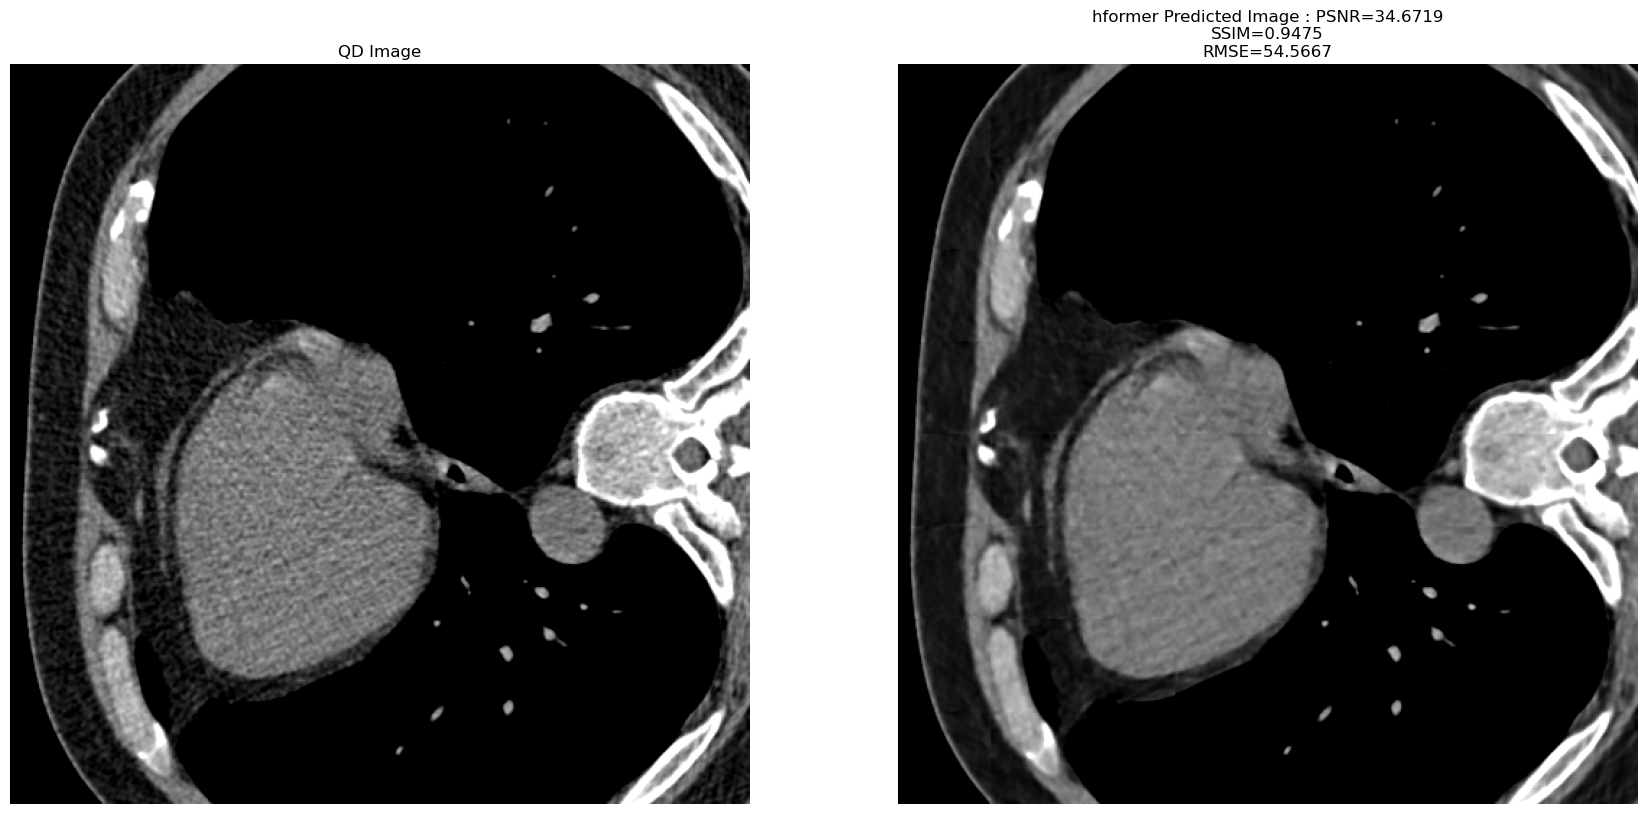

In [52]:
# View the predictions
patch_extractor = PatchExtractor(patch_size=64, stride=64, name="patch_extractor")
noisy_image_patches_array = patch_extractor(noisy_array)

hformer_prediction_patches = hformer_model.predict(noisy_image_patches_array)
hformer_predictions = np.expand_dims(reconstruct_image_from_patches(hformer_prediction_patches[0:64], 8), axis=0)

for i in range(1, int(hformer_prediction_patches.shape[0] / 64)): 
    reconstructed_image = reconstruct_image_from_patches(hformer_prediction_patches[i * 64 : i * 64 + 64], num_patches_per_row=8)
    reconstructed_image = np.expand_dims(reconstructed_image, axis=0)

    hformer_predictions = np.append(hformer_predictions, reconstructed_image, axis=0)
visualize_predictions(hformer_predictions, noisy_array,  1, hformer_predictions, "hformer")

## Model 2 : Pridnet Model 

In [53]:
sys.path.append('../denoising-models/pridnet/')
from pridnet_model import get_pridnet_model

pridnet_model = get_pridnet_model()
pridnet_model.load_weights('../denoising-models/pridnet/data/pridnet_saved.h5')
print('Model summary : ')
print(pridnet_model.summary())

Input = (None, 256, 256, 1)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 4)

Multi-scale feature extraction = (None, 256, 256, 19)
Kernel Selection Module = (None, 256, 256, 3)
Model summary : 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_block (Convoluti  (None, 256, 256, 64  111424     ['input_layer[0][0]']            
 onal_block)                    )                                                      

In [54]:
# Get prediction images.
import cv2
resized_noisy_array = []

for img in noisy_array:
    resized_img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA )
    resized_noisy_array.append(resized_img)

resized_noisy_array = np.array(resized_noisy_array)
pridnet_predictions_256x256 = pridnet_model.predict(resized_noisy_array)

pridnet_predictions = []
for img in pridnet_predictions_256x256:
    resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC ).astype(np.float64)
    pridnet_predictions.append(resized_img)

1/1 [==============================] - 70s 70s/step


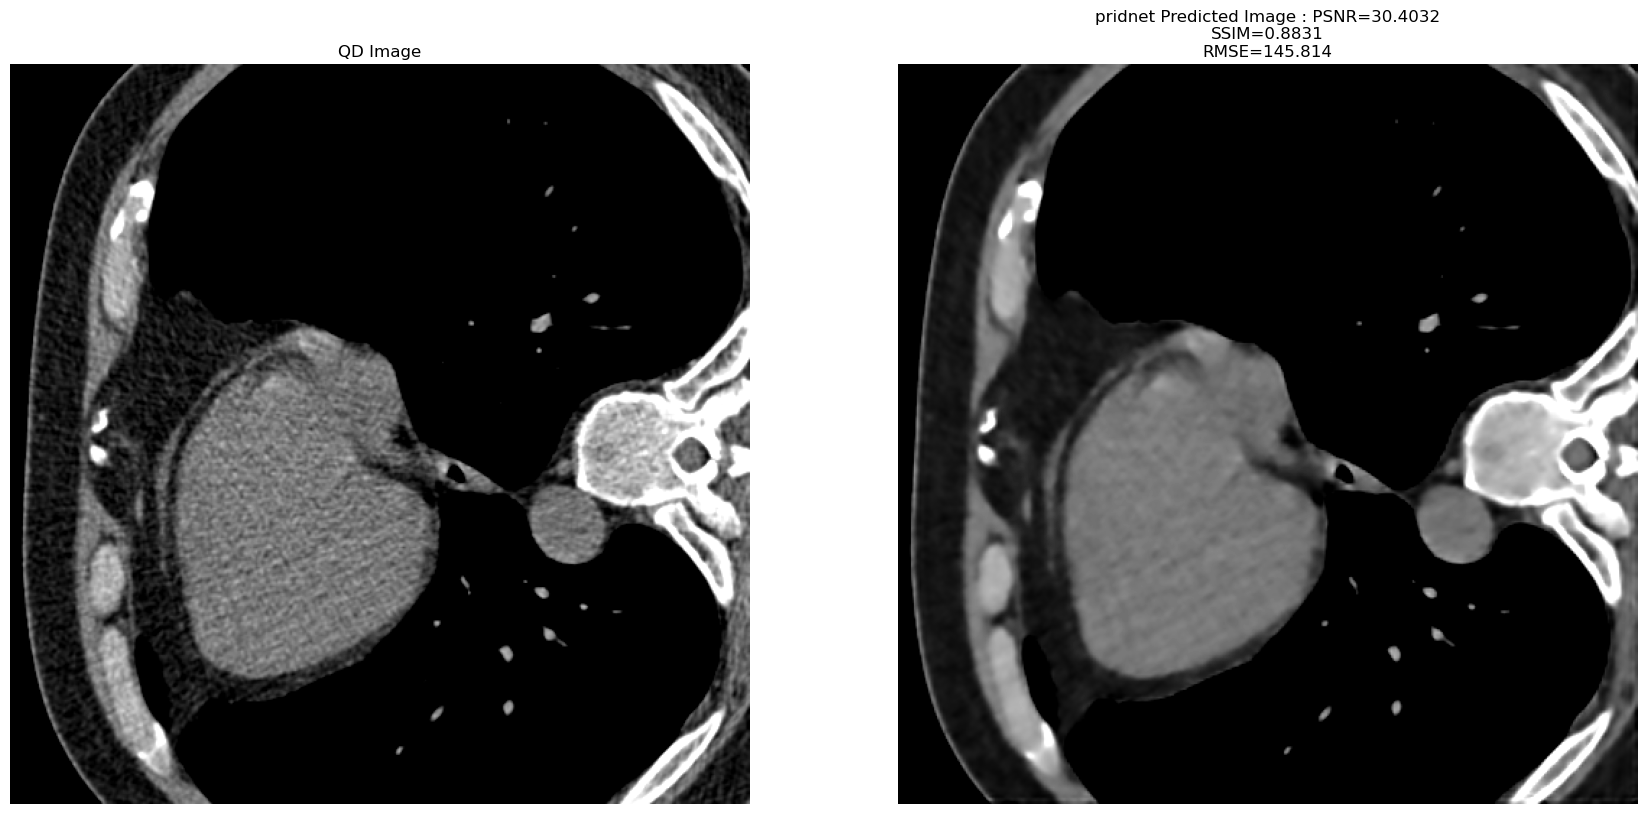

In [55]:

visualize_predictions(pridnet_predictions, noisy_array,  1, pridnet_predictions, "pridnet")
#visualize_predictions(pridnet_model, noisy_array, gt_array, len(gt_array), pridnet_predictions, "pridnet")

## Model 3 : MWCNN

In [56]:
sys.path.append('../denoising-models/mwcnn/')
from mwcnn_model import get_mwcnn_model

mwcnn_model = get_mwcnn_model()
mwcnn_model.load_weights('../denoising-models/mwcnn/data/mwcnn_saved.h5')
print('Model summary : ')
print(mwcnn_model.summary())

Model summary : 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_block (Conv_block)        (None, 256, 256, 64  74496       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 128, 128, 25  0          ['conv_block[0][0]']             
 ling)                          6)                                           

In [57]:
# Get prediction images.

mwcnn_predictions_256x256 = mwcnn_model.predict(resized_noisy_array)

mwcnn_predictions = []
for img in mwcnn_predictions_256x256:
    resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC ).astype(np.float64)
    mwcnn_predictions.append(np.expand_dims(resized_img, axis=-1))

1/1 [==============================] - 45s 45s/step


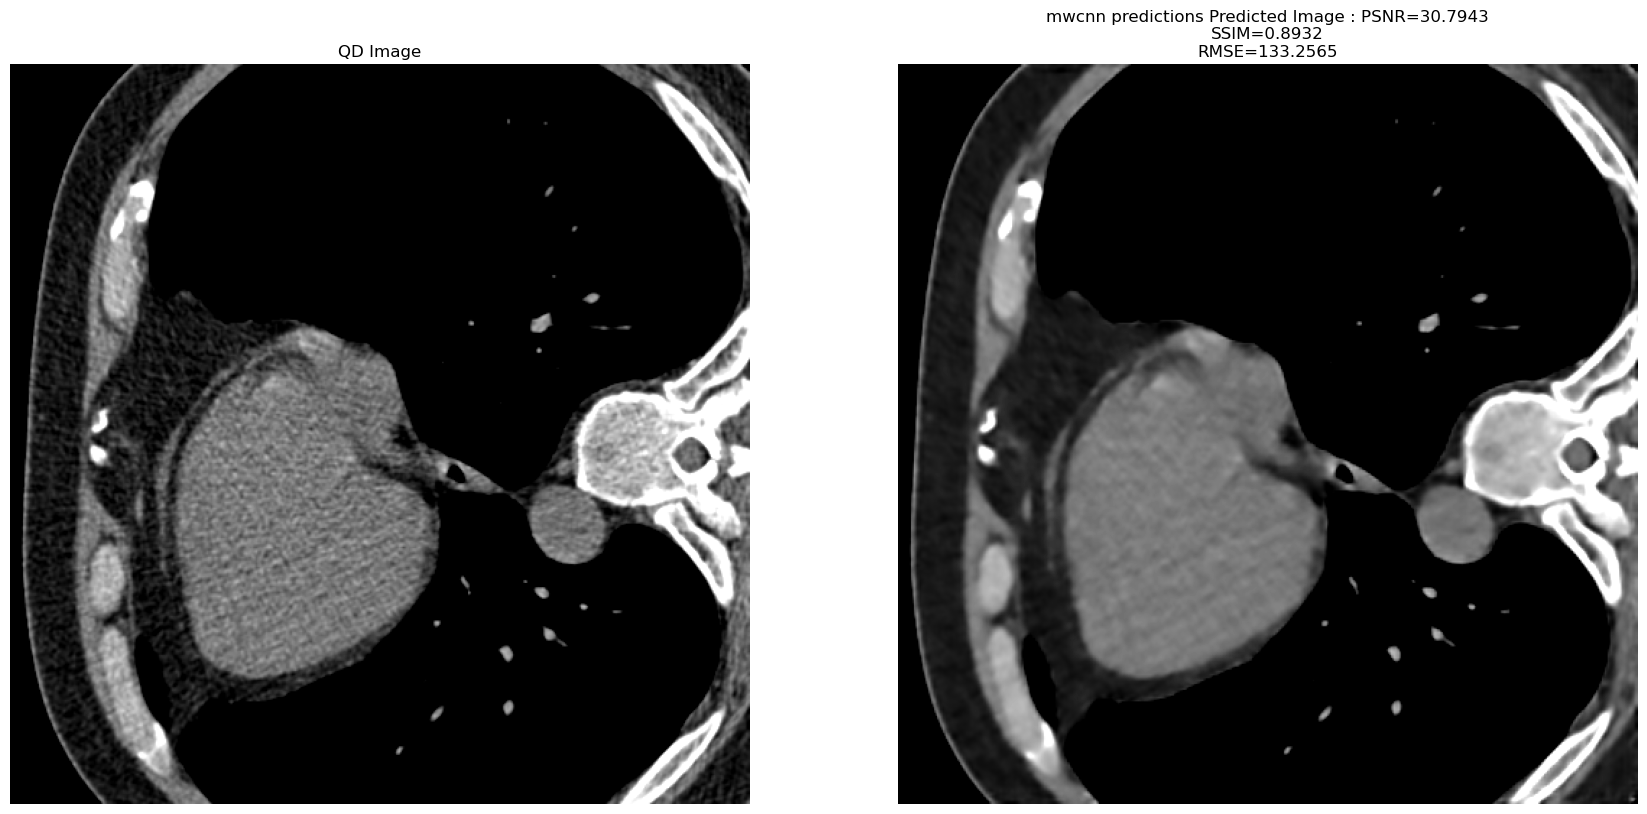

In [58]:

visualize_predictions(mwcnn_predictions, noisy_array,  1, mwcnn_predictions, "mwcnn predictions")

# Model 4 : WGAN-VGG

In [59]:

import sys
sys.path.append('../denoising-models/wgan_vgg/')

from torchinfo import summary
from networks import WGAN_VGG

wgan_vgg_model = WGAN_VGG(input_size=80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wgan_vgg_model.to(device)

saved_state_dict = torch.load('../denoising-models/wgan_vgg/save/WGANVGG_54000iter.pth')
wgan_vgg_model.load_state_dict(saved_state_dict)

print('Model summary : ')
summary(wgan_vgg_model, (1, 80, 80))

Model summary : 


Layer (type:depth-idx)                   Output Shape              Param #
WGAN_VGG                                 [1, 80, 80]               34,015,745
├─WGAN_VGG_generator: 1-1                [1, 80, 80]               --
│    └─Sequential: 2-1                   [1, 80, 80]               --
│    │    └─Conv2d: 3-1                  [32, 80, 80]              320
│    │    └─ReLU: 3-2                    [32, 80, 80]              --
│    │    └─Conv2d: 3-3                  [32, 80, 80]              9,248
│    │    └─ReLU: 3-4                    [32, 80, 80]              --
│    │    └─Conv2d: 3-5                  [32, 80, 80]              9,248
│    │    └─ReLU: 3-6                    [32, 80, 80]              --
│    │    └─Conv2d: 3-7                  [32, 80, 80]              9,248
│    │    └─ReLU: 3-8                    [32, 80, 80]              --
│    │    └─Conv2d: 3-9                  [32, 80, 80]              9,248
│    │    └─ReLU: 3-10                   [32, 80, 80]           

In [60]:

# Visualize the predictions
wgan_vgg_model.eval()

wgan_vgg_predictions = []

for img in noisy_array:
    img = img.reshape(1, 1, 512, 512)
    img_tensor = torch.from_numpy(img).float()
    img_tensor = img_tensor.to(device) 

    
    with torch.no_grad():
        output_tensor = wgan_vgg_model(img_tensor)
        output_tensor = output_tensor.cpu().numpy()
        output_tensor = output_tensor.reshape(512, 512, 1)
        
        wgan_vgg_predictions.append(output_tensor)

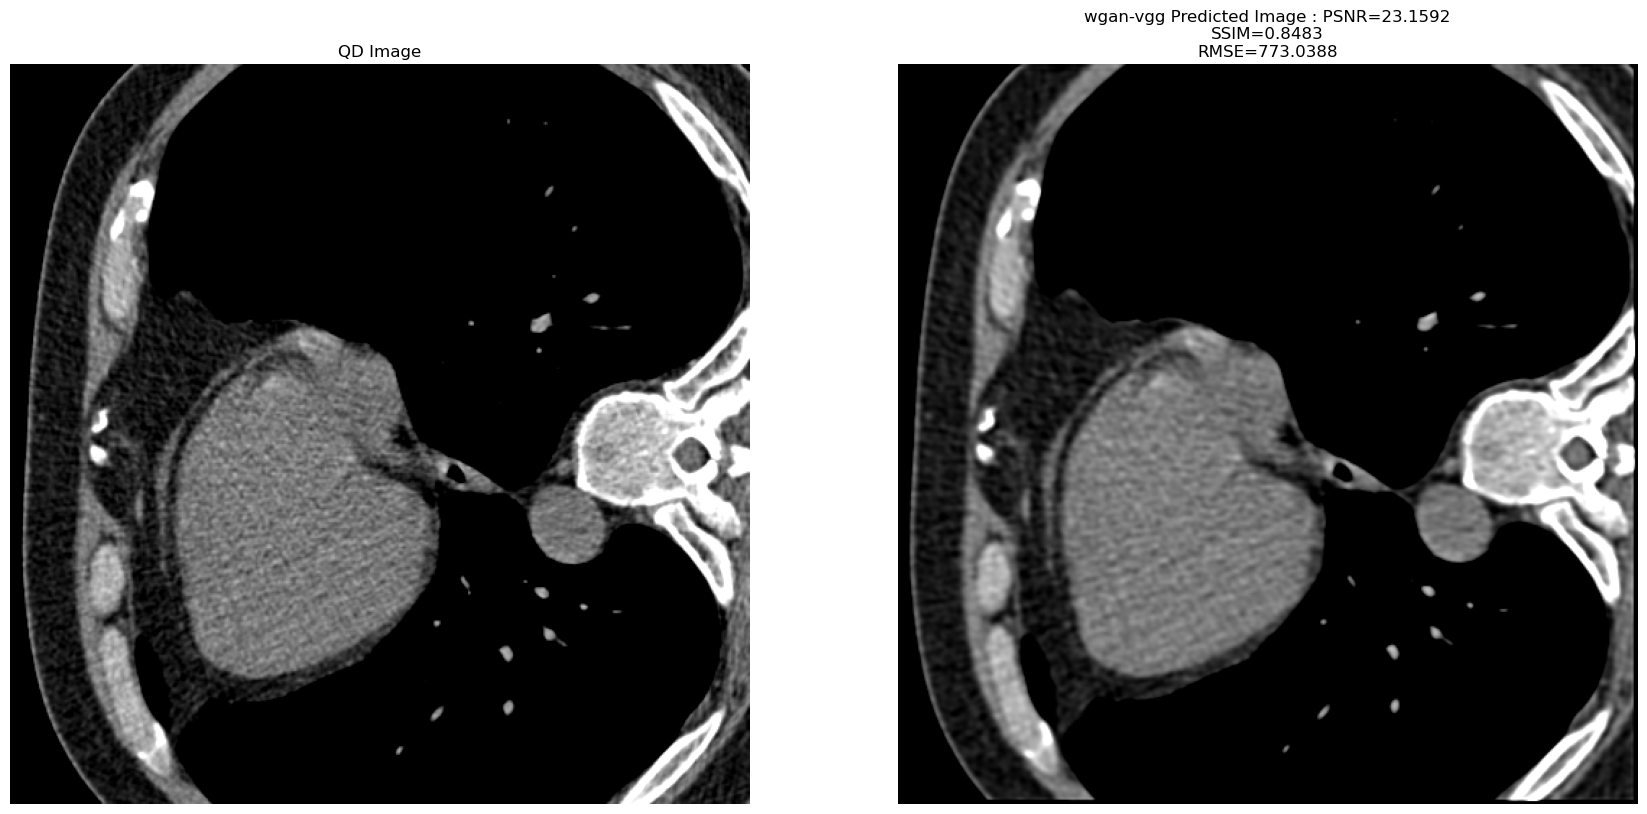

In [61]:

visualize_predictions(wgan_vgg_predictions, noisy_array,  1, wgan_vgg_predictions, "wgan-vgg")

## Part V : Side by side comparison of all models

In [62]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model", "PSNR", "SSIM", "MSE"]

hformer_metrics = get_average_metrics(hformer_predictions, noisy_array)
pridnet_metrics = get_average_metrics(pridnet_predictions, noisy_array)
mwcnn_metrics = get_average_metrics(mwcnn_predictions, noisy_array)
wgan_metrics = get_average_metrics(wgan_vgg_predictions, noisy_array)






Predicted average gt-predicted PSNR -> 31.333085565836644
Predicted average gt-predicted SSIM -> 0.8927535962287036
Predicted average gt-predicted MSE-> 242.6634189072392
Predicted average gt-predicted PSNR -> 27.396450673554053
Predicted average gt-predicted SSIM -> 0.8097552239316795
Predicted average gt-predicted MSE-> 432.7971953774707
Predicted average gt-predicted PSNR -> 27.587755634160747
Predicted average gt-predicted SSIM -> 0.8190160137428526
Predicted average gt-predicted MSE-> 417.27770224548505
Predicted average gt-predicted PSNR -> 22.18073597377285
Predicted average gt-predicted SSIM -> 0.7602992488686239
Predicted average gt-predicted MSE-> 1107.8968381078987


In [63]:
print(len(wgan_metrics))
print(wgan_metrics)
pt = PrettyTable()
pt.field_names = ["Model", "PSNR", "SSIM", "MSE"]
pt.add_row(["Original X-y pairs (No Model)", '-', '-', '-'])
pt.add_row(["WGAN-VGG",str(wgan_metrics[0]), str(wgan_metrics[1]), str(round(wgan_metrics[2], 4))])
pt.add_row(["Pridnet",str(pridnet_metrics[0]), str(pridnet_metrics[1]), str(round(pridnet_metrics[2], 4))])
pt.add_row(["MWCNN",str(mwcnn_metrics[0]), str(mwcnn_metrics[1]), str(round(mwcnn_metrics[2], 4))])
pt.add_row(["Hformer",str(hformer_metrics[0]), str(hformer_metrics[1]), str(round(hformer_metrics[2], 4))])
print(pt)

3
(22.1807, 0.7603, 1107.8968)
+-------------------------------+---------+--------+-----------+
|             Model             |   PSNR  |  SSIM  |    MSE    |
+-------------------------------+---------+--------+-----------+
| Original X-y pairs (No Model) |    -    |   -    |     -     |
|            WGAN-VGG           | 22.1807 | 0.7603 | 1107.8968 |
|            Pridnet            | 27.3965 | 0.8098 |  432.7972 |
|             MWCNN             | 27.5878 | 0.819  |  417.2777 |
|            Hformer            | 31.3331 | 0.8928 |  242.6634 |
+-------------------------------+---------+--------+-----------+


## Part 6 : Output of predictions of all 4 models side by side for direct visualize comparison

In [ ]:
def visualize_predictions_all_models(X_test,  n, hformer_predictions, pridnet_predictions, mwcnn_predictions, wgan_vgg_predictions):
    random_numbers = list(range(n))  # not very random
    for i in random_numbers:
        gt_image= X_test[i]

        hformer_pred = hformer_predictions[i]
        x_pred = pridnet_predictions[i]
        y_pred = mwcnn_predictions[i]
        sa_pred = wgan_vgg_predictions[i]

        models = ["HFORMER", "Pridnet", "MWCNN", "WGAN VGG"]
        predictions = [hformer_pred, x_pred, y_pred, sa_pred]

        # Display QD and FD images
        f, axarr = plt.subplots(1, 1 + len(models), figsize=(41,41))



        axarr[0].imshow(trunc(denormalize(gt_image)), cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[0].set_title("FD Image")
        axarr[0].set_axis_off()

        for j, (model_name, predicted_image) in enumerate(zip(models, predictions), start=1):
            if predicted_image.shape[-1] == 3:
                predicted_image = rgb2gray(predicted_image)

            psnr_recon = calculate_psnr(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))
            ssim_recon = calculate_ssim(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))
            rmse_recon = calculate_rmse(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))

            psnr_recon = round(psnr_recon, 4)
            ssim_recon = round(ssim_recon, 4)
            mse_recon = round(rmse_recon, 4)

            axarr[j].imshow(trunc(denormalize(predicted_image)), cmap='gray', vmin=-160.0, vmax=240.0)
            axarr[j].set_title("{}\nPSNR={}\nSSIM={}\nMSE={}".format(model_name, psnr_recon, ssim_recon, mse_recon))
            axarr[j].set_axis_off()

        plt.savefig('../../output/base_model_lodopab/combined_outputs_image_index_{}.png'.format(i))
        plt.show()

In [ ]:

visualize_predictions_all_models(noisy_array,  len(noisy_array), hformer_predictions, pridnet_predictions, mwcnn_predictions, wgan_vgg_predictions)